# Examples

In [ ]:
import ivim
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt

# Define output folder (can be any valid folder)
folder = os.path.join(tempfile.gettempdir(),'ivim_example')
if not os.path.exists(folder):
    os.mkdir(folder)

## Protocol optimization
Before acquiring data we might want to optimize our acquisition scheme. This can be done using a CRLB-based optimization. The input needed is expected IVIM parameter values of the particular IVIM model (referred to in terms of a specific regime, here the usual biexponential model with D* corresponding to the diffusive regime). We might also want to set a maximum b-value to avoid low SNR or kurtosis effects at higher b-values.

In [2]:
D = [0.8e-3, 1.0e-3]
f = [0.1, 0.15]
Dstar = [20e-3, 15e-3]
regime = ivim.models.DIFFUSIVE_REGIME
bmax = 800
res = ivim.optimize.crlb(D, f, regime, bmax=bmax, Dstar=Dstar)
bopt = np.round(res[0])
aopt = res[1]
print(f'b-values:    {bopt} s/mm2')
print(f'Proportions: {np.round(aopt*100)} %')

b-values:    [  0.  44. 222. 800.] s/mm2
Proportions: [16. 30. 36. 18.] %


The output is a tuple with two vectors corresponding to the optimized b-values and the fractional time one should spend acquiring data at each b-value. In other words, let's say that we have time to do 15 acquisitions, then we should use the following acquisition scheme:

In [3]:
n = 15
print('Acquisitions at each b-value')
for ai,bi in zip(aopt,bopt):
    print(f'{int(bi):3d}: {int(np.round(ai*n))}')

b = np.repeat(bopt.T,np.round(aopt*n).astype(int))
print(f'\nResulting b-value scheme: {b} s/mm2')

# Write the result to a bval file
bval_file = os.path.join(folder,'example.bval')
ivim.io.base.write_bval(bval_file, b)

Acquisitions at each b-value
  0: 2
 44: 5
222: 5
800: 3

Resulting b-value scheme: [  0.   0.  44.  44.  44.  44.  44. 222. 222. 222. 222. 222. 800. 800.
 800.] s/mm2


## Simulation
We can now go ahead and acquire our data. Here we will do so by simulations. Based on available maps of the IVIM parameters we can create noisy images based on the specific IVIM model. A simple square digital reference object is used here.

In [4]:
sz = [20,20,100]
pars = ['D','f','Dstar']
files_sim = {}
for par, vals in zip(pars, [D, f, Dstar]):
    im = vals[0] * np.ones(sz)
    im[sz[0]//4:3*sz[0]//4,sz[1]//4:3*sz[1]//4,:] = vals[1]
    files_sim[par] = os.path.join(folder, f'sim_{par}.nii.gz')
    ivim.io.base.write_im(files_sim[par], im)

noise_sigma = 1/40 # SNR = 40, given S0 = 1 as default
outbase_sim = os.path.join(folder,'ivim_sim')
ivim.sim.noise(files_sim['D'], files_sim['f'], regime, bval_file, noise_sigma, outbase_sim, Dstar_file = files_sim['Dstar'])
im_file = outbase_sim + '.nii.gz'

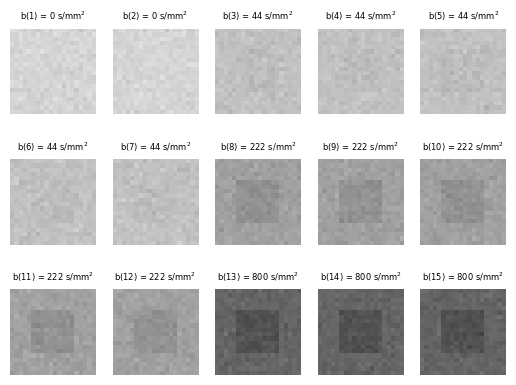

In [5]:
im = ivim.io.base.read_im(im_file)

fig,axes = plt.subplots(n//5,5)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(im[...,0,i], cmap='gray', vmin=0, vmax=1.2)
    ax.axis('off')
    ax.set_title(f'b({i+1}) = {int(b[i]):d} s/mm$^2$', fontsize = 6)

## Preprocessing
Some degree of preprocessing is usually required before model fitting. One example is directional averaging, meaning that data acquired with the same b-value but different diffusion encoding directions are averaged. While the simulation has not explicitly used different diffusion encoding directions, there are repetitions of b-values and the data can therefore be used to show this preprocessing step.

In [6]:
outbase_avg = os.path.join(folder,'comb')
ivim.preproc.base.average(im_file, bval_file, outbase_avg)
im_avg_file = outbase_avg + '.nii.gz'
bval_avg_file = outbase_avg + '.bval'

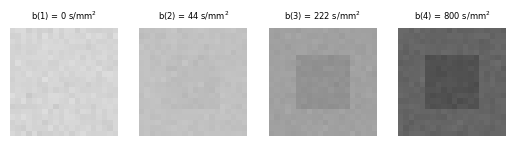

In [7]:
im_avg = ivim.io.base.read_im(im_avg_file)
b_avg = ivim.io.base.read_bval(bval_avg_file)

fig,axes = plt.subplots(1,4)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(im_avg[...,0,i], cmap='gray', vmin=0, vmax=1.2)
    ax.axis('off')
    ax.set_title(f'b({i+1}) = {int(b_avg[i]):d} s/mm$^2$', fontsize = 6)

## Model fitting
The final step is to generate IVIM parameter maps. We here use a segmented algorithm with a b-value threshold of 200 s/mm<sup>2</sup>.

In [8]:
outbase_fit = os.path.join(folder,'fit')
bthr = 200
ivim.fit.seg(im_avg_file, bval_avg_file, regime, bthr, outbase=outbase_fit)

Here the resulting parameter maps for a single slice.

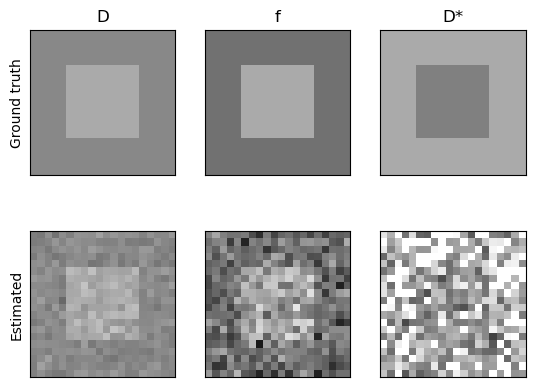

In [9]:
fig,axes = plt.subplots(2,3)
for par,plotpar,axs in zip(pars,['D*' if par == 'Dstar' else par for par in pars],axes.T):
    estmap = ivim.io.base.read_im(outbase_fit+f'_{par}.nii.gz')
    truemap = ivim.io.base.read_im(files_sim[par])
    for im,ax in zip([truemap,estmap],axs):
        ax.imshow(im[...,0], cmap='gray', vmin=0, vmax=1.5*np.max(truemap))
        ax.set_xticks([])
        ax.set_yticks([])
        if ax == axs[0]:
            ax.set_title(plotpar)
    if axs[0] is axes[0][0]:
        axs[0].set_ylabel('Ground truth')
        axs[1].set_ylabel('Estimated')
